In [1]:
%matplotlib widget
%reload_ext autoreload

size= (int(1e3),int(1e2))
size_bin=50
class Thresholding(widgets.HBox):
     
    def __init__(self, follow_temp=False, exposure_time=50, acquisition_time=2, Sky_LU=4, Signal=5.57e-18, EM_gain=1400,RN=109,CIC_charge=0.005, Dard_current=0.08,readout_time=1.5,x_axis='exposure_time',counting_mode=False,smearing=0.7,guider_noise=0,temperature=-100,threshold=-10):
        super().__init__()
        self.output = widgets.Output()
        self.guider_noise=guider_noise
        # time=np.linspace(1,150)
        # i = np.argmin(abs(time - exposure_time))
        # self.follow_temp=follow_temp
        # #exposure_time=time,
        Nominal = Observation(counting_mode=counting_mode, Signal=Signal, EM_gain=EM_gain, RN=RN, CIC_charge=CIC_charge, Dard_current=Dard_current, Sky_LU=10**Sky_LU, readout_time=readout_time, acquisition_time = acquisition_time,guider_noise=self.guider_noise,smearing=smearing,temperature=temperature)#,i=i#np.linspace(-110,-80))#
        flux = Nominal.Signal_el[0]#/exposure_time
        self.fig = Nominal.compute_optimal_threshold(flux = flux,dark_cic_sky_noise=None,plot_=True,title='',i=0,size=size,size_bin=size_bin,threshold=threshold)
        self.ax0 =  self.fig.axes[0]
        self.ax1 =  self.fig.axes[1]
    
        self.fig.canvas.toolbar_position = 'bottom'
        style={}
        width = '400px'
        small = '247px'
        small = '230px'
        psmall = '186px'
        vsmall = '147px'
        self.exposure_time = widgets.IntSlider( min=1, max=150,value=exposure_time, layout=Layout(width=width),description='Texp (s)')#'$t_{exp}$ (s)')
        self.acquisition_time = widgets.FloatSlider( min=0.1, max=10,value=acquisition_time, layout=Layout(width=width),description='Taq (h)')#'$t_{aq}$ (h)')
        self.Sky_LU = widgets.FloatLogSlider( min=4, max=7,value=Sky_LU,base=10, style =style, layout=Layout(width=width),description='Sky (LU)')
#         self.Signal = widgets. FloatLogSlider( min=-18, max=-15,value=1.25e-17, base=10,step=1e-18, style = style, layout=Layout(width='500px'),description='Flux')
#('Bright Galex star (mU~15)', 2.22e-14), 
        self.Signal = widgets.Dropdown(options=[('Extremely Bright QSO (mU~15)', 5.08e-15), ('Bright QSO (mU~19.5)', 3.51e-16),('Bright galaxy (mU~22.5)', 2.22e-17), ('Regular galaxy (mU~24)', 5.57e-18), ('Low SB galaxy (mU~25)', 2.2e-18), ('Cosmic web (1e-21)', 1e-21)],value=Signal,description='Flux', layout=Layout(width=width))
        self.EM_gain = widgets.IntSlider( min=200, max=2000,value=EM_gain, style = style, layout=Layout(width=width),description='EM gain')
        self.RN = widgets.IntSlider( min=30, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise')
        self.CIC_charge = widgets.FloatSlider( min=0.003, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f')#$_{charge}$
        self.readout_time = widgets.FloatSlider( min=0, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1)#$_{time}$
        self.follow_temp = widgets.Checkbox(value=follow_temp,description='Dark/Smearing follow temp',disabled=False, layout=Layout(width=width))
        options = ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing","temperature"] if follow_temp else ['exposure_time','Sky_LU','acquisition_time',"Signal","EM_gain","RN","CIC_charge","Dard_current" ,"readout_time","smearing"]
        self.x_axis=widgets.Dropdown(options=options,value=x_axis,description='X axis', layout=Layout(width=small))
        self.counting_mode = widgets.Checkbox(value=counting_mode,description='γ-Threshold',disabled=False, layout=Layout(width=psmall))
        self.temperature = widgets.FloatSlider( min=-120, max=-80,value=-90, style = style,description=r'Temp (C)',step=0.1, layout=Layout(width=width))
        self.smearing_poly = np.poly1d([-0.0306087, -2.2226087])#np.poly1d([-0.0453913, -3.5573913])
        self.dark_poly = np.poly1d([0.07127906, 6.83562573])
        
        self.threshold = widgets.FloatSlider( min=-10, max=20,value=-10, layout=Layout(width=width),description='Threshold/σ')#'$t_{aq}$ (h)')

        self.Dard_current = widgets.FloatSlider( min=10**self.dark_poly(-120), max=10**self.dark_poly(-80),value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f')#$_{current}$
        self.smearing = widgets.FloatSlider( min=self.smearing_poly(-80) , max=self.smearing_poly(-120),value=smearing, layout=Layout(width=width),description='Smearing',step=0.01)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
        self.temperature.layout.visibility = 'visible' if follow_temp else 'hidden'
        wids = widgets.interactive(self.update,x_axis=self.x_axis,smearing=self.smearing,counting_mode=self.counting_mode,exposure_time=self.exposure_time,Sky_LU=self.Sky_LU,acquisition_time=self.acquisition_time,Signal=self.Signal,EM_gain=self.EM_gain,RN=self.RN, CIC_charge=self.CIC_charge, Dard_current=self.Dard_current, readout_time=self.readout_time,temperature=self.temperature,follow_temp=self.follow_temp,threshold=self.threshold )
        if follow_temp:
            self.Dard_current.value = 10**np.poly1d([0.07127906, 6.83562573])(self.temperature.value)
            self.smearing.value = self.smearing_poly(self.temperature.value)#self.acquisition_time,
        controls = VBox([HBox([self.Signal,self.follow_temp ]),   HBox([self.Sky_LU,self.EM_gain,self.temperature])     ,  HBox([self.Dard_current,self.threshold,self.smearing]),    HBox([self.exposure_time,self.RN,self.CIC_charge]) ] )
        display(HBox([self.output,controls]))


    def update(self, x_axis,counting_mode,Sky_LU,acquisition_time,Signal,EM_gain,RN,CIC_charge,Dard_current,readout_time,exposure_time,smearing,temperature,follow_temp,threshold):
        """Draw line in plot"""
        with self.output:
            self.temperature.layout.visibility = 'visible' if follow_temp else 'hidden'
            if follow_temp:
                self.Dard_current.value = 10**self.dark_poly(temperature)
                self.smearing.value = self.smearing_poly(temperature)
            args, _, _, locals_ = inspect.getargvalues(inspect.currentframe())
            value = locals_[x_axis]
            if x_axis == 'temperature':
                temperature=np.linspace(self.temperature.min, self.temperature.max)
                Dard_current = 10**self.dark_poly(temperature)
                smearing = self.smearing_poly(temperature)
            new = Observation(exposure_time=exposure_time,Sky_LU=Sky_LU, acquisition_time=acquisition_time,counting_mode=counting_mode,Signal=Signal,EM_gain=EM_gain,RN=RN,CIC_charge=CIC_charge,Dard_current=Dard_current,readout_time=readout_time,smearing=smearing,guider_noise=self.guider_noise,i=0,temperature=temperature)
            new.compute_optimal_threshold(flux = new.Signal_el[0],dark_cic_sky_noise=None,plot_=True,title='',i=0,axes=[self.ax0, self.ax1],size=size,size_bin=size_bin,threshold=threshold)
            self.fig.canvas.draw()


# ETC = Thresholding(EM_gain=1700,RN=65, smearing=0.8,Dard_current=1,x_axis='exposure_time',counting_mode=True,follow_temp=False,Signal=2.22e-17)
# for this:
# add the fact that the bright object is only a small fraction of pixels (10% for instance)
# the other pixels are at the value of dark + sky + CIC and should take into account the exposure time right

NameError: name 'widgets' is not defined

### Analysis
- **Smearing:** At -120C, the low device's CTE smears the pixels' counts and then lowers the effective gain. This lowering factor is huge (>2) for a smearing length of 1.5, but is much smaller for a smearing length of 0.7 (~1.2). 
It seems that we already had a comparabale 0.7 smearing length with previous controller at 10MHz (tests February 7th and 8th 2019) at same EMgain (1600) and temperature (-95C). Which might mean that the 1MHz reading does not decrease significantly the smearing. **With the current (2022) smearing length, thresholding does not increase the SNR!! If we manage to invert the smearing, even if it doubles the readnoise, we could recover most of the thresholding efficiency.**
- **Photon-counting:** The thresholding effect can be misleading as it depends on Flux, EMgain, RN, smearing and noise($\sigma_{CIC}^2 + \sigma_{DC}^2+ \sigma_{SKY}^2$). But actually it depends mostly on the ratio $\frac{G_{EM,eff}}{RN}$. For a ratio >> 10 the thresholding is efficient. As stated above for a smearing length of 0.7, EMgain and effective_gain are close. A consequence of that, is that at the EMgains we use ($\sim1600$) and smearing $\sim 0.7$, the thresholding is almost as efficient with RN=50 and RN=107 as the ratio $\frac{G_{EM,eff}}{RN}$ stays >>10. This was not the case in 2018 when the smearing length was 1.5. This is why in photon counting mode, you will see a very small impact of read noise change.
- **Reading frequency tradeoff:** Based on above, the change from 10MHz to 1MHz as minor consequences on the total SNR.
    - In photon counting mode and with low smearing, the decrease of the RN has quasi no effect (~1%) on the SNR
    - The transition from 1.4 to 3sec readout would mean a loss of SNR of ~2%, transition to 10sec about ~10% 
    - Therefore the real critical point is the possible need to add or not a shutter above the tank with the 1MHz controller as it will complexify guidance
- **Temperature Tradeoff:** Conclusion depends on the definition of SNR on thresholded images (see below): In both cases, the SNR decreases with smearing but in one case smearing has more important impact and compensate  dark current giving rise to an optimal temperature. Though, the fact that we will never get rid of dark current while we could actually manage to inverse the smearing could suggest staying at low temperature (-120 to -110).

 
  
  
|             **Parameters**             |          **2022 1Mhz controller**           | **Values 2018** |
| :------------------------------------: | :-----------------------------------------: | :-------------: |
|          **Temperature (C)**           |                     -95                     |      -115       |
|       **Conversion gain ADU/e-**       |                    1/4.5                    |      0.53       |
|           **Read noise e-**            |            50 -> 60 longer cable            |       107       |
|         **pCIC e− /pix/frame**         |                    0.003                    |      0.004      |
|         **sCIC e− /pix/frame**         |                   ~0.002                    |     ~0.002      |
|  **semi-amplified CIC e− /pix/frame**  |                    ~0.02                    |     ~0.03-4     |
|           **EM gain  e-/e-**           |          O                    2000          |      1400       |
|   **Smearing exponent. length pix**    |              L~0.6 ± 0.1  pix               |   L~1.5 ± 0.1   |
|       **Dark current e− /pix/h**       |                   ~2±0.5                    |   0.5 ± 0.03    |
| **Cosmetics % pixels bottom detector** |                     ~2%                     |   <<1% (TBD)    |
|         **Exposure time sec**          |                     50                      |       50        |
|          **Readout time sec**          | ~10 (all), ~3(physical) +2 better clearance |      ~1.4       |


In [2]:
            # self.ax2.collections.clear()
            # self.ax1.collections.clear()
            # self.ax2.clear()
            # self.ax1.clear()

            # self.Nominal.stackplot1.clear()
            # self.Nominal.stackplot2.clear()
            # [b.remove() for b in self.Nominal.stackplot2]
            # [b.remove() for b in self.Nominal.stackplot1]
            # for l in self.Nominal.stackplot1:
            #     # l.remove([])
            #     # l.remove()
            #     self.Nominal.stackplot1.remove(l)
            # for l in self.Nominal.stackplot2:
            #     # l.remove()
            #     self.Nominal.stackplot2.remove(l)


                # self.ax3.lines[2].set_data(locals_[x_axis],  np.log10(self.new.extended_source_5s/np.sqrt(40)))
                # self.ax3.lines[2].set_label("20 sources stacked on 2 res elem. (%0.2f-%0.2f)"%(np.log10(self.new.point_source_5s[arg]/np.sqrt(40)),np.nanmin(np.log10(self.new.point_source_5s/np.sqrt(40)))))
                # self.ax3.lines[3].set_data(locals_[x_axis],  np.log10(self.new.extended_source_5s/np.sqrt(2)/30))
                # self.ax3.lines[3].set_label("Sources transported to high z: (%0.2f-%0.2f) \ngain of factor 22-50 depending on line resolution"%(np.log10(self.new.point_source_5s[arg]/np.sqrt(2)/30),np.nanmin(np.log10(self.new.point_source_5s/np.sqrt(2)/30))))
            # print(self.new.extended_source_5s.min()/np.sqrt(2)/30)
                # self.ax3.lines[2].set_data([locals_[x_axis].min(),locals_[x_axis].min(),np.nan,locals_[x_axis].max(),locals_[x_axis].max()],[[self.Nominal.T2(self.Nominal.pow_2018),self.Nominal.T2(self.Nominal.pow_best),np.nan,self.Nominal.T2(self.Nominal.pow_2018),self.Nominal.T2(self.Nominal.pow_best)]])
                # try:
                #     self.ax3.set_ylim((  np.nanmin(   np.log10(self.new.extended_source_5s/np.sqrt(2)/30)),    np.nanmax(  np.log10(self.new.extended_source_5s))))
                # except ValueError:
                #     pass


In [2]:
# import matplotlib.pyplot as plt
from astropy.io import fits

class Analize_thresholding(widgets.HBox):
     
    def __init__(self):
        super().__init__()
        self.output = widgets.Output()
        values = [0,1,2,3]
        values.remove(1)
        values.remove(0)
        self.n=6
        gains=np.round(np.linspace(800,2500,self.n),4)
        rons=np.round(np.linspace(30,120,self.n),4)
        fluxes=np.round(np.linspace(0.01,0.3,self.n),4)
        smearings=np.round(np.linspace(0,2,self.n),4)
        # noise=np.round(np.linspace(0.002,0.05,n),4)
        # gains=np. linspace(800,2500,n)
        # rons=np.linspace(30,120,n)
        # fluxes=np. linspace(0.01,1.51,m)
        # smearings=np. linspace(0,2,n)
        i=0
        self.threshold = fits.open('threshold_%i.fits'%(self.n))[0].data
        self.fraction_flux = fits.open('fraction_flux_%i.fits'%(self.n))[0].data
        self.fraction_rn = fits.open('fraction_rn_%i.fits'%(self.n))[0].data
        self.snrs = fits.open('snr_max_%i.fits'%(self.n))[0].data

        self.threshold = fits.open('interp_threshold_%i.fits'%(self.n))[0].data
        self.fraction_flux = fits.open('interp_fraction_flux_%i.fits'%(self.n))[0].data
        self.fraction_rn = fits.open('interp_fraction_rn_%i.fits'%(self.n))[0].data
        self.snrs = fits.open('interp_snr_max_%i.fits'%(self.n))[0].data

        # self.snrs /= self.snrs.max()
        # popt,pcov = curve_fit(fourDpolynomy_6,(gi.flatten(),ri.flatten(),fi.flatten(),si.flatten()),fraction_flux.flatten())
        # res_fract_flux =  fourDpolynomy_6((gi,ri,fi,si),*popt)
        value=2
        image_threshold = self.threshold.take(0,axis=value).take(0,axis=value)
        image_fraction_flux = self.fraction_flux.take(0,axis=value).take(0,axis=value)
        image_fraction_rn = self.fraction_rn.take(0,axis=value).take(0,axis=value)
        image_snr = self.snrs.take(0,axis=value).take(0,axis=value)
        self.options=[('Gain', 0), ('RON',1), ('Flux',2),('Smearing',3)]
        self.names =[['Gain',gains],['RON',rons], ['Flux',fluxes],['Smearing',smearings]]
        
        x,y=0,1
        self.fig,self.axes  = plt.subplots(2,2,sharey=True,sharex='col',figsize=(10,8))
        for ax,im,title in zip(self.axes.flatten(),[image_fraction_flux,image_fraction_rn,image_snr,image_threshold],['Flux fraction kept','RN fraction kept','Thresholding SNR gain','Optimal threshold']):
            # print(i)
            ax.clear()
            ax.imshow(im, extent=[self.names[y][1].min(),self.names[y][1].max(),self.names[x][1].max(),self.names[x][1].min()], aspect="auto")
        # im = ax.imshow(image, extent=[rons.min(),rons.max(),gains.max(),gains.min()], aspect="auto")
        # im = ax.imshow(image, extent=[names[x][1].min(),names[x][1].max(),names[y][1].max(),names[y][1].min()], aspect="auto")
        # im = ax.imshow(image, extent=[names[y][1].min(),names[y][1].max(),names[x][1].max(),names[x][1].min()], aspect="auto")
            ax.set_title(title)

            for xi in range(im.shape[0]):
                for yi in range(im.shape[1]):    
                    ax.text(1/(self.n*2) + yi/self.n, 1/(self.n*2)+xi/self.n, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
        self.axes.flatten()[2].set_xlabel(self.names[y][0])
        self.axes.flatten()[3].set_xlabel(self.names[y][0])
        self.axes.flatten()[0].set_ylabel(self.names[x][0])
        self.axes.flatten()[2].set_ylabel(self.names[x][0])
        self.fig.tight_layout()
        # self.i_w =  widgets.IntSlider( min=0, max=4,value=0,description='i')
        # self.j_w =  widgets.IntSlider( min=0, max=4,value=0,description='j')
        self.i_w =  widgets.SelectionSlider(options=self.names[values[0]][1],description='Flux',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.3f')
        self.j_w =  widgets.SelectionSlider(options=self.names[values[1]][1],description='Smearing',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.3f')        

        self.y_w =  widgets.Dropdown(options=self.options,value=1,description='First axis')
        # options = self.options
        # options.remove((self.y_w.label,self.y_w.index))
        self.x_w =  widgets.Dropdown(options=self.options,value=0,description='Second axis')
        wids = widgets.interactive(self.show_thresholding,i=self.i_w,j=self.j_w,x=self.x_w,y=self.y_w)
        controls = VBox([HBox([self.i_w ,self.y_w  ]),   HBox([ self.j_w,self.x_w ])   ] )
        display(HBox([self.output,controls]))

    def show_thresholding(self,i,j,x,y):
        with self.output:
            values = [0,1,2,3]
            if x==y:
                # print(list(set(values) -set([y])))
                self.x_w.value = list(set(values) -set([y]))[0]
                x=self.x_w.value
            if x>y:
                x,y=y,x
            values.remove(x)
            values.remove(y)
            # image = fraction_flux2.take(i,axis=values[0])#fraction_flux2[]
            i_  = self.i_w.index
            j_  = self.j_w.index

            image_threshold = self.threshold.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            image_fraction_flux = self.fraction_flux.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            image_fraction_rn = self.fraction_rn.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            image_snr = self.snrs.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flu
      # image_res_fraction_rn = res_fract_flux.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            
            self.i_w.description = self.names[values[0]][0]
            self.j_w.description = self.names[values[1]][0]
            self.i_w.options = self.names[values[0]][1]
            self.j_w.options = self.names[values[1]][1]
            
            
            
            for ax,im,title in zip(self.axes.flatten(),[image_fraction_flux,image_fraction_rn,image_snr,image_threshold],['Flux fraction kept','RN fraction kept','Thresholding SNR gain','Optimal threshold']):
                ax.clear()
                ax.imshow(im, extent=[self.names[y][1].min(),self.names[y][1].max(),self.names[x][1].max(),self.names[x][1].min()], aspect="auto")
                ax.set_title(title)
                for xi in range(im.shape[0]):
                    for yi in range(im.shape[1]):    
                        ax.text(1/(self.n*2) + yi/self.n, 1/(self.n*2)+xi/self.n, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
            self.axes.flatten()[2].set_xlabel(self.names[y][0])
            self.axes.flatten()[3].set_xlabel(self.names[y][0])
            self.axes.flatten()[0].set_ylabel(self.names[x][0])
            self.axes.flatten()[2].set_ylabel(self.names[x][0])

Analize_thresholding()
#- why the SNR does not peak at F=0.1e-


NameError: name 'widgets' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Fonction pour générer une galaxie spirale avec un noyau central
def generate_realistic_spiral_galaxy(num_arms=2, intensity=1.0, size=512, noise=0.02, core_brightness=2.0):
    # Crée une grille pour les coordonnées (x, y)
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(x, y)
    
    # Convertit les coordonnées cartésiennes en coordonnées polaires
    r = np.sqrt(xx**2 + yy**2)  # Rayon
    theta = np.arctan2(yy, xx)  # Angle
    
    # Génération du noyau central avec une fonction gaussienne
    core = core_brightness * np.exp(-r**2 * 100)
    
    # Équation pour simuler une galaxie spirale
    spiral = np.exp(-r**2 * 10) * (1 + intensity * np.sin(num_arms * theta + r * 20))
    
    # Combinaison du noyau central et des bras spiraux
    galaxy = core + spiral
    
    # Ajoute un peu de bruit pour plus de réalisme
    galaxy += noise * np.random.normal(size=galaxy.shape)
    
    # Normalise l'image pour rester entre 0 et 1
    galaxy = np.clip(galaxy, 0, 1)
    return galaxy

# Fonction pour mettre à jour et afficher l'image
def update_plot(num_arms=2, intensity=1.0, size=512, noise=0.02, core_brightness=2.0):
    galaxy_image = generate_realistic_spiral_galaxy(num_arms, intensity, size, noise, core_brightness)
    
    # Affichage de l'image
    vmin, vmax = np.nanmin(galaxy_image), np.nanmax(galaxy_image)

    plt.figure(figsize=(6, 6))
    plt.imshow(galaxy_image, vmin=vmin, vmax=vmax) #, origin="lower", cmap="inferno"
    # plt.axis("off")
    plt.colorbar()
    plt.title(f"S-type Galaxy Simulation\nNum Arms={num_arms}, Intensity={intensity}, Core={core_brightness}")
    plt.show()

# Création des widgets interactifs
num_arms_widget = widgets.IntSlider(value=2, min=1, max=6, step=1, description="Num Arms")
intensity_widget = widgets.FloatSlider(value=1.0, min=0.5, max=2.0, step=0.1, description="Intensity")
size_widget = widgets.IntSlider(value=512, min=256, max=1024, step=128, description="Size")
noise_widget = widgets.FloatSlider(value=0.02, min=0.0, max=0.1, step=0.01, description="Noise")
core_brightness_widget = widgets.FloatSlider(value=2.0, min=1.0, max=5.0, step=0.1, description="Core Brightness")

# Connecte les widgets à la fonction de mise à jour
interactive_plot = widgets.interactive(update_plot, 
                                       num_arms=num_arms_widget, 
                                       intensity=intensity_widget, 
                                       size=size_widget, 
                                       noise=noise_widget, 
                                       core_brightness=core_brightness_widget)

# Affiche les widgets et le plot interactif
display(interactive_plot)

interactive(children=(IntSlider(value=2, description='Num Arms', max=6, min=1), FloatSlider(value=1.0, descrip…

In [ ]:
import numpy as np
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
import ipywidgets as widgets
from IPython.display import display

# Constants
size_kpc = 10.0  # Physical size of the galaxy in kpc
intensity = 0.4
final_image_size = 500  # Number of pixels per side of the output image

def generate_spiral_galaxy(amplitude,redshift, platescale, PSF_RMS):
    """
    Generates a simulated galaxy image of defined size and PSF.
    
    Parameters:
    redshift (float): Redshift of the galaxy.
    platescale (float): Size of one pixel in arcsec/pix.
    PSF_RMS (float): RMS size of the PSF in arcsec.
    
    Returns:
    np.ndarray: Simulated and convolved 2D galaxy image.
    """


    angular_size_arcsec = size_kpc / cosmo.kpc_proper_per_arcmin(redshift).to(u.kpc / u.arcsec).value
    angular_size_pix = angular_size_arcsec / platescale

    field_of_view_arcsec = platescale * final_image_size
    x = np.linspace(-field_of_view_arcsec / 2, field_of_view_arcsec / 2, final_image_size)
    y = np.linspace(-field_of_view_arcsec / 2, field_of_view_arcsec / 2, final_image_size)
    xx, yy = np.meshgrid(x, y)
    r = np.sqrt(xx**2 + yy**2)
    theta = np.arctan2(yy, xx)
    
    core = np.exp(-r**2 / (2 * (angular_size_arcsec / 5 / 2.355)**2))
    spiral = np.exp(-r**2 / (2 * (angular_size_arcsec / 2.355)**2)) * (1 + intensity * np.sin(2 * theta + r * 20 / angular_size_arcsec))
    galaxy = core + spiral

    # Normalize the galaxy to conserve total energy
    galaxy_sum_initial = np.max(galaxy)*100
    galaxy *= amplitude /galaxy_sum_initial  # Normalize so that the sum is 1
    galaxy *= size_kpc * size_kpc  # Scale to maintain the total energy constant

    PSF_RMS_pix = np.sqrt(PSF_RMS**2 + 0.05**2) / platescale
    galaxy_convolved = gaussian_filter(galaxy, PSF_RMS_pix)

    return galaxy_convolved

def update_plot(redshift_target, PSF_RMS_det, platescale,flux):
    """
    Updates the plot of the simulated galaxy.
    """
    galaxy_image = generate_spiral_galaxy(flux,redshift_target, platescale, PSF_RMS_det)

    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(galaxy_image)
    vmin, vmax = np.nanmin(galaxy_image), np.nanmax(galaxy_image)

    field_of_view_arcsec = platescale * final_image_size
    field_of_view_kpc = field_of_view_arcsec * cosmo.kpc_proper_per_arcmin(redshift_target).to(u.kpc/u.arcsec)
    
    fig, ax = plt.subplots(2, 1, figsize=(6, 8), gridspec_kw={'height_ratios': [5, 1]})

    im = ax[0].imshow(galaxy_image, origin='lower', cmap='inferno', vmin=vmin, vmax=vmax,
                      extent=(-field_of_view_arcsec / 2, field_of_view_arcsec / 2, 
                              -field_of_view_arcsec / 2, field_of_view_arcsec / 2))
    ax[0].set_title(f"z={redshift_target:.2f}, PSF={PSF_RMS_det:.2f}\", Plate scale={platescale:.2f}, Sum={np.sum(galaxy_image):.2E}",fontsize=10)
    ax[0].set_xlabel("Arcseconds")
    ax[0].set_ylabel("Arcseconds")
    plt.colorbar(im, ax=ax[0], orientation='vertical', label="Flux (e-/pix)")

    secax_x = ax[0].secondary_xaxis('top', functions=(lambda x: x * cosmo.kpc_proper_per_arcmin(redshift_target).to(u.kpc/u.arcsec).value,
                                                      lambda x: x / cosmo.kpc_proper_per_arcmin(redshift_target).to(u.kpc/u.arcsec).value))
    secax_x.set_xlabel('Kiloparsecs')

    central_row = galaxy_image[final_image_size // 2, :]
    ax[1].plot(central_row, color='black')
    ax[1].set_xlim(0, final_image_size)
    ax[1].set_title("Intensity Profile (Center Row)")
    ax[1].set_xlabel("Pixel")
    ax[1].set_ylabel("Flux (e-/pix)")

    fig.tight_layout()
    plt.show()

# Widgets for interactivity
redshift_widget = widgets.FloatSlider(value=0.1, min=0.01, max=2.0, step=0.01, description='Redshift:')
psf_widget = widgets.FloatSlider(value=0.0, min=0.0, max=5.0, step=0.1, description='PSF ("):')
platescale_widget = widgets.FloatSlider(value=0.01, min=0.01, max=1.0, step=0.01, description='Plate scale ("/pix):')
flux_widget = widgets.FloatSlider(value=1, min=0.01, max=1000, step=0.01, description='Flux :')

interactive_plot = widgets.interactive(update_plot, flux=flux_widget, redshift_target=redshift_widget, PSF_RMS_det=psf_widget, platescale=platescale_widget)
display(interactive_plot)


interactive(children=(FloatSlider(value=0.1, description='Redshift:', max=2.0, min=0.01, step=0.01), FloatSlid…

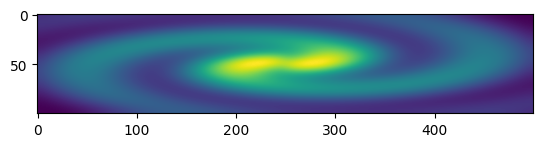

In [110]:
plt.imshow(generate_spiral_galaxy(0.1, 0.01, 0.01))

In [101]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from scipy.ndimage import zoom, gaussian_filter
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
import ipywidgets as widgets
from IPython.display import display

# Initial parameters
initial_redshift = 0.01
redshift_target = 1.03
zeropoint = 27
signal_flux = 1e-17
pixel_scale_instrument = 0.1
PSF_RMS_det = 2.0

# Load FITS file
file_path = "/tmp/galaxy_image_processed.fits"
file_path = "/Users/Vincent/Nextcloud/OWNCLOUD_CNRS/Keynotes/DS9Presentation/CESAM/STIFF/calexp-HSC-G-17270-22_modified_trim.fits"

with fits.open(file_path) as hdul:
    image_data = hdul[0].data
    header = hdul[0].header

# WCS object
wcs = WCS(header)

# Z-scale interval for color mapping
zscale = ZScaleInterval()

def update_plot(redshift_target, PSF_RMS_det, signal_flux):
    # Calculate scale ratio
    kpc_per_arcsec_z0 = cosmo.kpc_proper_per_arcmin(initial_redshift).to(u.kpc / u.arcsec).value
    kpc_per_arcsec_target = cosmo.kpc_proper_per_arcmin(redshift_target).to(u.kpc / u.arcsec).value
    scale_ratio = kpc_per_arcsec_target / kpc_per_arcsec_z0

    # Convert flux to electron flux
    image_flux = (image_data - np.nanpercentile(image_data, 10)) * signal_flux / np.nanmax(image_data - np.nanpercentile(image_data, 10))

    # Rescale image for redshift
    image_dezoomed = zoom(image_flux, 1 / scale_ratio, order=1)

    # Adjust image size
    target_height, target_width = 100, 500
    current_height, current_width = image_dezoomed.shape
    pad_y_top, pad_y_bottom = (target_height - current_height) // 2, target_height - current_height - (target_height - current_height) // 2
    pad_x_left, pad_x_right = (target_width - current_width) // 2, target_width - current_width - (target_width - current_width) // 2

    if current_height < target_height:
        image_dezoomed = np.pad(image_dezoomed, ((pad_y_top, pad_y_bottom), (0, 0)), mode="constant", constant_values=0)
    if current_width < target_width:
        image_dezoomed = np.pad(image_dezoomed, ((0, 0), (pad_x_left, pad_x_right)), mode="constant", constant_values=0)

    # Convolve with PSF
    PSF_RMS_pix = PSF_RMS_det / pixel_scale_instrument
    image_convolved = gaussian_filter(image_dezoomed, PSF_RMS_pix, mode="constant")

    # Final image
    vmin_new, vmax_new = zscale.get_limits(image_convolved)
    
    # Plot the transformed image
    # plt.figure(figsize=(6, 6))
    # plt.imshow(image_convolved, origin='lower', cmap='inferno', vmin=vmin_new, vmax=vmax_new)
    # plt.title(f"Image Transformée (z={redshift_target:.2f}, PSF={PSF_RMS_det:.2f}, Flux={signal_flux:.1e})")
    # plt.colorbar(label="Flux (e-/pix)")
    # plt.tight_layout()
    # plt.show()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Affichage de l'image originale avec sa colorbar
    im1 = ax1.imshow(image_data, origin='lower', cmap='viridis', vmin=vmin_orig, vmax=vmax_orig)
    ax1.set_title("Image originale")
    fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
    # Affichage de l'image transformée avec sa colorbar
    im2 = ax2.imshow(image_convolved, origin='lower', cmap='inferno', vmin=vmin_new, vmax=vmax_new)
    ax2.set_title("Image transformée")
    fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)

    # Ajustement des espaces entre les sous-plots
    plt.tight_layout()
    plt.show()


# Widgets
redshift_widget = widgets.FloatSlider(value=redshift_target, min=0.01, max=1.0, step=0.01, description='Redshift:',continuous_update=False)
psf_widget = widgets.FloatSlider(value=PSF_RMS_det, min=0.5, max=5.0, step=0.1, description='PSF ("):',continuous_update=False)
flux_widget = widgets.FloatLogSlider(value=signal_flux, min=-18, max=-15, step=0.1, description='Flux:',continuous_update=False)

# Interactivity
interactive_plot = widgets.interactive(update_plot, redshift_target=redshift_widget, PSF_RMS_det=psf_widget, signal_flux=flux_widget)
display(interactive_plot)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Redshift:', max=1.0, min=0.…

scale_ratio = 39.09997920969216


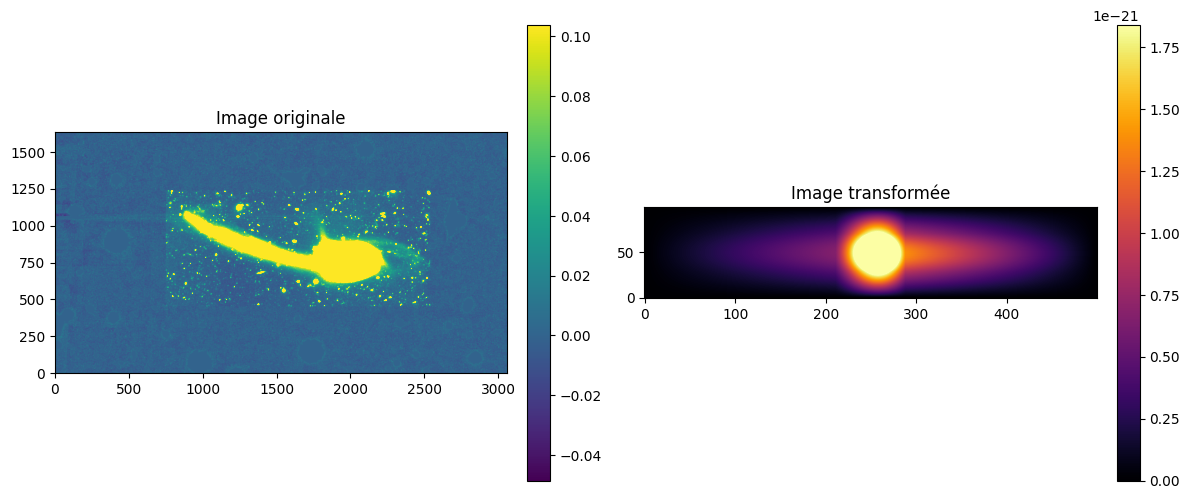

In [85]:
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from scipy.ndimage import zoom, gaussian_filter
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

# Paramètres de l'image et du calculateur SNR
initial_redshift = 0.01  # Redshift cible
redshift_target = 1.03  # Redshift cible
zeropoint = 27  # Magnitude zéro (remplace par 27 si c'est le bon)
signal_flux = 1e-17  # Flux cible en erg/s/cm^2/arcsec^2/Å
pixel_scale_instrument = 0.1  # Échelle en "/pix pour l'instrument (remplace par la valeur adéquate)
PSF_RMS_det = 2.0  # RMS de la PSF de l'instrument en arcsec

# Étape 1 : Ouverture de l'image FITS
file_path = "/Users/Vincent/Github/fireball2-etc/galaxy.fits"  # Remplace par le chemin du fichier
file_path = "/Users/Vincent/Nextcloud/OWNCLOUD_CNRS/Keynotes/DS9Presentation/CESAM/STIFF/calexp-HSC-G-17270-22_modified_trim.fits"
with fits.open(file_path) as hdul:
    image_data = hdul[0].data
    header = hdul[0].header

# Création d'un objet WCS
wcs = WCS(header)

# Étape 2 : Conversion de l'échelle pour simuler un décalage vers un autre redshift
# Calcul du ratio d'échelle entre z=0 et le redshift cible
kpc_per_arcsec_z0 = cosmo.kpc_proper_per_arcmin(initial_redshift).to(u.kpc / u.arcsec).value
kpc_per_arcsec_target = cosmo.kpc_proper_per_arcmin(redshift_target).to(u.kpc / u.arcsec).value
scale_ratio = kpc_per_arcsec_target / kpc_per_arcsec_z0
print("scale_ratio =",  scale_ratio)
# Modification de la WCS pour ajuster l'échelle à z cible
# wcs.wcs.cd *= scale_ratio

# Étape 3 : Re-calibration du flux d'image à un flux cible
# Conversion du flux en erg/s/cm^2/arcsec^2/Å avec le zeropoint
# image_flux = 10**(-0.4 * (image_data - zeropoint)) * signal_flux / np.max(10**(-0.4 * (image_data - zeropoint)))
# image_flux = 10**(0.4 * (zeropoint - image_data)) * signal_flux / np.max(10**(0.4 * (zeropoint - image_data)))
image_flux = (image_data - np.nanpercentile(image_data,10)) * signal_flux / np.nanmax (image_data - np.nanpercentile(image_data,10))
# Étape 4 : Réinterpolation sur la nouvelle échelle de l'instrument
# Calcul du facteur d'interpolation basé sur l'échelle des pixels
pixel_scale_initial = np.abs(wcs.pixel_scale_matrix[0, 0]) * 3600  # En arcsec/pix
rescale_factor = pixel_scale_initial / pixel_scale_instrument

image_dezoomed = zoom(image_flux, 1 / scale_ratio, order=1)  # Interpolation bilinéaire

# Dimensions cibles
target_height, target_width = 100, 500

# Taille actuelle de l'image dézoomée
current_height, current_width = image_dezoomed.shape

# Vérification et ajustement de la hauteur
if current_height < target_height:
    # Calcul des paddings nécessaires pour atteindre 100 pixels en hauteur
    pad_y_top = (target_height - current_height) // 2
    pad_y_bottom = target_height - current_height - pad_y_top
else:
    # Rognage central si l'image est plus grande que 100 pixels en hauteur
    pad_y_top = pad_y_bottom = 0
    start_y = (current_height - target_height) // 2
    image_dezoomed = image_dezoomed[start_y:start_y + target_height, :]

# Vérification et ajustement de la largeur
if current_width < target_width:
    # Calcul des paddings nécessaires pour atteindre 500 pixels en largeur
    pad_x_left = (target_width - current_width) // 2
    pad_x_right = target_width - current_width - pad_x_left
else:
    # Rognage central si l'image est plus grande que 500 pixels en largeur
    pad_x_left = pad_x_right = 0
    start_x = (current_width - target_width) // 2
    image_dezoomed = image_dezoomed[:, start_x:start_x + target_width]



# Étape 6 : Convolution avec la PSF
# Taille de la PSF en pixels
PSF_RMS_pix = PSF_RMS_det / pixel_scale_instrument
image_convolved = gaussian_filter(image_dezoomed, PSF_RMS_pix,mode="constant")


# Application du padding si nécessaire
image_final = np.pad(
    image_convolved,
    ((pad_y_top, pad_y_bottom), (pad_x_left, pad_x_right)),
    # mode='reflect',
    # mode='edge',
    # mode='edge',
    # mode='edge',
    # mode='edge',
    mode='linear_ramp',
    # constant_values=np.nanpercentile(image_convolved,1)
    end_values=0
)





# Sauvegarde de l'image traitée dans un nouveau fichier FITS
hdu = fits.PrimaryHDU(data=image_final, header=wcs.to_header())
hdu.writeto("/tmp/galaxy_image_processed.fits", overwrite=True)



# Création denew_image l'intervalle de visualisation pour ajuster automatiquement les échelles
new_image = image_final
zscale = ZScaleInterval()
# Paramètres d'affichage pour ajuster les plages de couleur automatiquement
vmin_orig, vmax_orig = zscale.get_limits(image_data)
vmin_new, vmax_new = zscale.get_limits(new_image)
# Création de la figure avec deux sous-plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Affichage de l'image originale avec sa colorbar
im1 = ax1.imshow(image_data, origin='lower', cmap='viridis', vmin=vmin_orig, vmax=vmax_orig)
ax1.set_title("Image originale")
fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
# Affichage de l'image transformée avec sa colorbar
im2 = ax2.imshow(new_image, origin='lower', cmap='inferno', vmin=vmin_new, vmax=vmax_new)
ax2.set_title("Image transformée")
fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)

# Ajustement des espaces entre les sous-plots
plt.tight_layout()
plt.show()


In [5]:
# from plotly.offline import download_plotlyjs, init_notebook_mode,  plot, init_notebook_mode, iplot
# import plotly.io as pio 
# import plotly.graph_objects as go
# from IPython.display import display, Javascript
# from astropy.table import Table
# import plotly
# from plotly.graph_objs import graph_objs as go
# import numpy as np 
# # plotly.offline.init_notebook_mode()
# from plotly.offline import iplot

# display(Javascript("""
# window._encodeURI = window._encodeURI || encodeURI;
# encodeURI = uri => _encodeURI(uri)
#     .replace('%2523', '%23')  // #
#     .replace('%253A', '%3A')  // :
#     .replace('%252b', '%2b'); // +
# """))

# cat=Table.read('parameters.csv')
# columns = cat.colnames
# # cat=cat.to_pandas()
# def Create_label(cat,L):
#     if L is not None:
#         text = [l + ' = ' + np.round(cat[l],3).astype(str) + '<br>'  for l in L if l in cat.columns]
#         return np.sum(text,axis=0)
#     else:
#         return None
    
# def layout_update(fig,title=''):
#     layout = go.Layout(
#         height = 600,
#         width = 1400/1.5,
#         title=title,
#         legend_title="Legend",  
#         paper_bgcolor='rgba(0,0,0,0)',
#         plot_bgcolor='rgba(0,0,0,0)',
#         xaxis2=dict(domain=[0.3, 0.7],anchor='y2'),
#         yaxis2=dict(domain=[0.75, 0.9],anchor='x2'))
#     # fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
#     fig.update_layout(layout)
#     return fig

# def ScatterPlot( cat,fig=None,x='X_pix',y='y_pix',L=['Internal-count','z','FUV_APP','NUV_APP'],err=20/3600,url='url',size='NUV',color='NUV',name='',**kwargs):
# #     cat = cat.to_pandas()

#     cat['ok']=True
#     if url is None:#·
#         cat['url'] = ["<a href=\'http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=%0.7fd%0.7fd&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=2&Radius.unit=arcmin'>%s</a>" %(ra,dec,'-')for ra,dec in zip(cat[x],cat[y])]
#         url='url'
    
#     if fig==None:
#         fig=go.Figure()

#     text = Create_label(cat,L)

#     if type(size) is str:
#         size=cat[size]
    
        
#     if color is None:
#         colorscale=None
#         colorbar=None
#         showscale=False
#         cmin, cmax = None, None
#     else:
#         colorscale="gray"#"Cividis"#"gray"#'viridis'#
#         colorbar = dict(title=color,len=0.6)
#         color = cat.eval(color)
#         showscale=True
#         # cmin, cmax = np.min(color), np.max(color)

# #     colorscale=None if color is None else 'viridis'
# #     color=None if color is None else 'viridis'
#     #cat['ok']=True
#     trace=go.Scatter(x=cat.eval(x),
#                     y=cat.eval(y),
#                     # error_x=dict(type='data',array=err*np.ones((len(cat)))),#,thickness=50,width=1#0.120
#                     mode='markers+text',
#                     # marker_symbol=cat['symbol'][cat['ok']],#hovertemplate = '%{text}<extra></extra>',
#                     textfont=dict(
#                     family="sans serif",
#                     size=18,
#                     color="black",colorsrc='black'),#textposition="bottom center",
#                     marker=dict(
#                     line=dict(width=1),
#                     size=size,
#                     color=color,
#                     colorscale=colorscale,#cmax=cmax,cmin=cmin,
#                     showscale=showscale,colorbar=colorbar),text=cat[url][cat['ok']],
#                     hovertext = text,name=name,**kwargs)
#     fig.add_trace(trace)
#     fig.update_layout(go.Layout(xaxis_title=x,yaxis_title=y))
#     return fig, trace, cat['ok']



# class test(widgets.HBox):
     
#     def __init__(self,x='log10(exposure)',y='log10(flux)',c='EmGain',q='DAQ==9800 & exposure>0',q2='',q3=''):
#         super().__init__()
#         self.output = widgets.Output()
#         cat['url'] = ["<a href=\'%s'>%s</a><a href=\'%s'>%s</a>" %("https://github.com/vpicouet/notebooks/blob/main/figures/%s.png"%(path.replace('.csv','')),'+',"https://raw.githubusercontent.com/vpicouet/notebooks/main/figures/%s.png"%(path.replace('.csv','')),'+') for path in cat['name']]
#         # cat['url'] = ["<a href=\'%s'>%s</a>" %("https://raw.githubusercontent.com/vpicouet/fireball2-etc/main/notebooks/figures/%s.png"%(path.replace('.csv','')),'+') for path in cat['name']]
# #         cat['url'] = ["<a href=\'file://%s'>%s</a>" %(path,'+')for path in cat['Path']]
# #         print(cat['url'][0])
# #         cat['url'] = ["<a href=\'%s'>%s</a>" %('/runtime.txt','+')for path in zip(cat['Path'])]
# #         cat['url'] =["<a href=\'https://nuage.osupytheas.fr/apps/files/?dir=/%s'>%s</a>" %(path[29:],'+')for path in zip(cat['Path'])]

#         x1 = widgets.Combobox(value=x,placeholder='Type something',description='x =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         y1 = widgets.Combobox(value=y,placeholder='Type something',description='y =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         c1 = widgets.Combobox(value=c,placeholder='Type something',description='color =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         q1 = widgets.Combobox(value=q,placeholder='Type something',description='query1 =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         q2 = widgets.Combobox(value=q2,placeholder='Type something',description='y2 =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         q3 = widgets.Combobox(value=q3,placeholder='Type something',description='query2 =',disabled=False, continuous_update=False,options=columns,ensure_option=False)
#         wids = widgets.interact(self.view_image, x=x1,y=y1,c=c1,q=q1, q2=q2,q3=q3)


#     def view_image(self,x,y,c,q,q2,q3):
#     # try:
#         if q=='':
#             q="EmGain>-1"
#         if c=='':
#             c="EmGain"    
# #         columns = [ col for col in cat.colnames if ((type(cat[col][0])==int)|(type(cat[col][0])==float))]
#         # print(cat.colnames)
#         columns = ['date','DAQ','temperature','exposure','bias','RN','EmGain','flux','sCIC','smearing']#cat.colnames[:]#[f for f in cat.colnames if np.isscalar(cat[f][0])] #['exposure','EmGain']#,'IMNO','TEMPA','Col2ColDiff_pre_scan','Line2lineDiff_pre_scan','SaturatedPixels','pre_scan','post_scan','stdXY_pre_scan','BottomImage','TopImage','bias','Amp','bias_fit','RON','Gain1','Gain2','Flux1','Flux2','gain_ls','flux_ls','sCIC_ls','sCIC_OS']
#         fig, trace1, _ = ScatterPlot(cat.to_pandas().query(q),x=x,y=y,L=columns,url='url',size=20,line=dict(width=2),color=c,name='y Query 1',marker_symbol='circle')
#         if (q2!=""):
#             fig, trace1, _ = ScatterPlot(cat.to_pandas().query(q),x=x,y=q2,fig=fig,L=columns,url='url',size=10,line=dict(width=2),color=c,marker_symbol='square',name='y2 query 1')
#         if (q3!=""):
#             fig, trace1, _ = ScatterPlot(cat.to_pandas().query(q3),x=x,y=y,fig=fig,L=columns,url='url',size=20,line=dict(width=2),color=c,marker_symbol='diamond',name='y Query 2')
#             if (q2!=""):
#                 fig, trace1, _ = ScatterPlot(cat.to_pandas().query(q3),x=x,y=q2,fig=fig,L=columns,url='url',size=20,line=dict(width=2),color=c,marker_symbol='hexagon',name='y2 Query 2')

#         layout_update(fig)
#         iplot(fig)
#     # except Exception :
#         # print('Wrong expression. You must use columns in this list:\n', list(cat.columns))

# # controls = VBox([HBox([x,y]),   HBox([c,q])   ] )
# # display(HBox([widgets.Output(),controls]))
# # interact(view_image, x=x,y=y,c=c,q=q)

# test(y='log10(flux)')

In [6]:
# %matplotlib inline
# from ipywidgets import interactive
# import matplotlib.pyplot as plt
# import numpy as np

# a = Table.read("/Volumes/SSDPICOUET/drift/HeaderCatalogtest_slit_thermal_drift.ecsv")

#     # plt.show()
#         # return np.nan*a["slit_%s_spatial"%(1+1)][j]
# # def f2(x, i, j):
# #     try:
# #         print( a["slit_%s_spectral"%(i+1)][j])
# #         return a["slit_%s_spectral"%(i+1)][j]
# #     except KeyError as e :
# #         print(e)
# #         return np.nan*a["slit_%s_spectral"%(1+1)][j]
# # fig.canvas.draw()

# fig, ax = plt.subplots()
# ax.plot(0,0)

# def f(i, j):
#     # plt.figure(2)
    
#     try:
#         y = a["slit_%s_spatial"%(i+1)][j]
#         # print( a["slit_%s_spatial"%(i+1)][j])
#         # plt.plot(a["slit_%s_spatial"%(i+1)][j])
#         # l[0].set_ydata(a["slit_%s_spatial"%(i+1)][j])
#         ax.lines[0].set_data(np.arange(len(y)),y)
#     except KeyError as e :
#         print(e)
#     # fig.draw()
#     fig.canvas.draw()
#     plt.show()
  
    
# interactive_plot = interact(f,  j=widgets.IntSlider(value=1, min=1, max=len(a)), i=widgets.IntSlider(value=1, min=1, max=32))
# # plt.show()
# # output = interactive_plot.children[-1]
# # output.layout.height = '350px'
# interactive_plot

In [7]:
# %matplotlib widget
# import mpl_interactions.ipyplot as iplt
# import matplotlib.pyplot as plt
# import numpy as np
# a = Table.read("/Volumes/SSDPICOUET/drift/HeaderCatalogtest_slit_thermal_drift.ecsv")
# y0=a["slit_%s_spatial"%(2)][1]
# x = np.arange(len(y0))
# # tau = np.linspace(0.5, 10, 100)

# def f1(x,i, j):
#     # plt.figure(2)
#     print(i,j)
#     print(a["slit_%s_spatial"%(i+1)][int(j)])
#     return a["slit_%s_spatial"%(i+1)][int(j)]
#     # try:
#     #     y = a["slit_%s_spatial"%(i+1)][j]
#     #     # print( a["slit_%s_spatial"%(i+1)][j])
#     #     # plt.plot(a["slit_%s_spatial"%(i+1)][j])
#     #     # l[0].set_ydata(a["slit_%s_spatial"%(i+1)][j])
#     #     # ax.lines[0].set_data(np.arange(len(y)),y)
#     #     return y
#     # except KeyError as e :
#     #     print(e)
#     #     return y0*np.nan


# fig, ax = plt.subplots()
# controls = iplt.plot(x, f1, i=widgets.IntSlider(value=1, min=1, max=32), j=widgets.IntSlider(value=1, min=1, max=len(a)),label="profile")
# # iplt.plot(x, f2, controls=controls, label="f2")
# _ = plt.legend()
# plt.show()

In [8]:
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# import sys
# from astropy.table import Table
# cat = Table.read('/Users/Vincent/Github/fireball2-etc/notebooks/parameters.csv')
# n_conv=11
# import matplotlib.backends.backend_pdf
# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
# # import PdfPages
# l=[]

# for  i,line in enumerate(cat[:]):
#     bias ,    RN   , EmGain ,  flux  ,smearing ,  sCIC=line[line.colnames[-6:]]
#     hist = Table.read('/Users/Vincent/Github/fireball2-etc/notebooks/histograms/Histogram_' + line['name'])
#     fig, ax = plt.subplots()
#     ax2=inset_axes(ax,width="30%", height="30%", loc="upper center")
#     conv = 0.53 if line['RN']>70 else 1/4.5 
#     n=5*line['RN']*conv #100
#     ax2.set_ylim((hist['col2'].max()/100,hist['col2'].max()))
#     # ax2.set_autoscalex_on(True)
#     # ax2.autoscale_view()
#     ax2.set_xlim((bias-n,bias+n))

#     np.savetxt("/tmp/xy.txt", np.array([hist['col0'],np.log10(hist['col1'])]).T)
    
#     from pyds9plugin.Macros.Fitting_Functions.functions import EMCCDhist, EMCCD
#     for axi in [ax,ax2]:
#         for i in ['1','2']:
#             axi.semilogy(hist['col0'],hist['col'+i],'k',alpha=0.2)
#             conv = 10**np.convolve(np.log10(hist['col'+i]), np.ones(n_conv) / n_conv, mode="same")
#             axi.semilogy(hist['col0'][conv>0],conv[conv>0],'k:',alpha=1)
                
#         # sys.path.append("../../../../pyds9plugin")
#     y = np.convolve( EMCCDhist(hist['col0'],*line[line.colnames[-6:]],)  , np.ones(n_conv) / n_conv, mode="same")
#     lab = ''.join([c+' : %s\n'%(line[c]) for c in line.colnames[1:]])
#     ax.semilogy(hist['col0'],10**  y,'k',alpha=1,label=lab)
#     ax2.semilogy(hist['col0'],10**  y,'r:',alpha=1)
#     ax.legend(fontsize=9)
#     # l = line[line.colnames[-6:]]
#     line['flux']=0
#     y = np.convolve( EMCCDhist(hist['col0'],*line[line.colnames[-6:]],)  , np.ones(n_conv) / n_conv, mode="same")
#     ax.semilogy(hist['col0'],10**  y,'k',alpha=1)
#     ax2.semilogy(hist['col0'],10**  y,'r:',alpha=1)
#     fig.tight_layout()
#     ax.set_xlabel('ADU')
#     ax.set_xlabel('# Occurences')
#     ax.set_title('%s : %s'%(i,line['name']))
#     # with pdf:
#     l.append(fig)
#     plt.savefig('/Users/Vincent/Github/notebooks/figures/'+line['name'].replace('.csv','.png'), dpi=100, bbox_inches="tight")


In [9]:
# # import matplotlib.pyplot as plt
# from astropy.io import fits

# class Analize_thresholding(widgets.HBox):
     
#     def __init__(self):
#         super().__init__()
#         self.output = widgets.Output()
#         values = [0,1,2,3,4]
#         values.remove(1)
#         values.remove(0)
#         n=5
#         gains=np.round(np.linspace(800,2500,n),4)
#         rons=np.round(np.linspace(30,120,n),4)
#         fluxes=np.round(np.linspace(0.01,0.3,n),4)
#         smearings=np.round(np.linspace(0,2,n),4)
#         noise=np.round(np.linspace(0.002,0.05,n),4)
#         self.options=[('Gain', 0), ('RON',1), ('Flux',2),('Smearing',3),('Noise',4)]
#         self.names =[['Gain',gains],['RON',rons], ['Flux',fluxes],['Smearing',smearings],['Noise',noise]]
#         # gains=np. linspace(800,2500,n)
#         # rons=np.linspace(30,120,n)
#         # fluxes=np. linspace(0.01,1.51,m)
#         # smearings=np. linspace(0,2,n)
#         i=0
#         self.threshold = fits.open('threshold_%i.fits'%(n))[0].data
#         self.fraction_flux = fits.open('fraction_flux_%i.fits'%(n))[0].data
#         self.fraction_rn = fits.open('fraction_rn_%i.fits'%(n))[0].data
#         self.snrs = fits.open('snr_max_%i.fits'%(n))[0].data
#         ## self.snrs /= self.snrs.max()
#         # popt,pcov = curve_fit(fourDpolynomy_6,(gi.flatten(),ri.flatten(),fi.flatten(),si.flatten()),fraction_flux.flatten())
#         # res_fract_flux =  fourDpolynomy_6((gi,ri,fi,si),*popt)
#         value=2
#         image_threshold = self.threshold.take(0,axis=value).take(0,axis=value).take(0,axis=value)
#         image_fraction_flux = self.fraction_flux.take(0,axis=value).take(0,axis=value).take(0,axis=value)
#         image_fraction_rn = self.fraction_rn.take(0,axis=value).take(0,axis=value).take(0,axis=value)
#         image_snr = self.snrs.take(0,axis=value).take(0,axis=value).take(0,axis=value)
        
#         x,y=0,1
#         self.fig,self.axes  = plt.subplots(2,2,sharey=True,sharex='col',figsize=(10,8))
#         for ax,im,title in zip(self.axes.flatten(),[image_fraction_flux,image_fraction_rn,image_snr,image_threshold],['Flux fraction kept','RN fraction kept','SNR max','Optimal threshold']):
#             # print(i)
#             ax.clear()
#             ax.imshow(im, extent=[self.names[y][1].min(),self.names[y][1].max(),self.names[x][1].max(),self.names[x][1].min()], aspect="auto")
#         # im = ax.imshow(image, extent=[rons.min(),rons.max(),gains.max(),gains.min()], aspect="auto")
#         # im = ax.imshow(image, extent=[names[x][1].min(),names[x][1].max(),names[y][1].max(),names[y][1].min()], aspect="auto")
#         # im = ax.imshow(image, extent=[names[y][1].min(),names[y][1].max(),names[x][1].max(),names[x][1].min()], aspect="auto")
#             ax.set_title(title)

#             for xi in range(im.shape[0]):
#                 for yi in range(im.shape[1]):    
#                     ax.text(1/(n*2) + yi/n, 1/(n*2)+xi/n, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
#         self.axes.flatten()[2].set_xlabel(self.names[y][0])
#         self.axes.flatten()[3].set_xlabel(self.names[y][0])
#         self.axes.flatten()[0].set_ylabel(self.names[x][0])
#         self.axes.flatten()[2].set_ylabel(self.names[x][0])
#         self.fig.tight_layout()
#         # self.i_w =  widgets.IntSlider( min=0, max=4,value=0,description='i')
#         # self.j_w =  widgets.IntSlider( min=0, max=4,value=0,description='j')
#         self.i_w =  widgets.SelectionSlider(options=self.names[values[0]][1],description='Flux',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.3f')
#         self.j_w =  widgets.SelectionSlider(options=self.names[values[1]][1],description='Smearing',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.3f')        
#         self.k_w =  widgets.SelectionSlider(options=self.names[values[2]][1],description='Noise',disabled=False,continuous_update=False,orientation='horizontal',readout=True,readout_format='.3f')        

#         self.y_w =  widgets.Dropdown(options=self.options,value=1,description='First axis')
#         # options = self.options
#         # options.remove((self.y_w.label,self.y_w.index))
#         self.x_w =  widgets.Dropdown(options=self.options,value=0,description='Second axis')
#         wids = widgets.interactive(self.show_thresholding,i=self.i_w,j=self.j_w,k=self.k_w,x=self.x_w,y=self.y_w)
#         controls = VBox([HBox([self.i_w ,self.y_w  ]),   HBox([ self.j_w,self.x_w ]) ,   HBox([ self.k_w])   ] )
#         display(HBox([self.output,controls]))

#     def show_thresholding(self,i,j,k,x,y):
#         with self.output:
#             values = [0,1,2,3,4]
#             if x==y:
#                 # print(list(set(values) -set([y])))
#                 self.x_w.value = list(set(values) -set([y]))[0]
#                 x=self.x_w.value
#             if x>y:
#                 x,y=y,x
#             values.remove(x)
#             values.remove(y)
#             # image = fraction_flux2.take(i,axis=values[0])#fraction_flux2[]
#             i_  = self.i_w.index
#             j_  = self.j_w.index
#             k_  = self.k_w.index

#             image_threshold = self.threshold.take(i_,axis=values[0]).take(j_,axis=values[1]-1).take(k_,axis=values[2]-2)
#             image_fraction_flux = self.fraction_flux.take(i_,axis=values[0]).take(j_,axis=values[1]-1).take(k_,axis=values[2]-2)
#             image_fraction_rn = self.fraction_rn.take(i_,axis=values[0]).take(j_,axis=values[1]-1).take(k_,axis=values[2]-2)
#             image_snr = self.snrs.take(i_,axis=values[0]).take(j_,axis=values[1]-1).take(k_,axis=values[2]-2)
#       # image_res_fraction_rn = res_fract_flux.take(i_,axis=values[0]).take(j_,axis=values[1]-1)#fraction_flux2[]
            
#             self.i_w.description = self.names[values[0]][0]
#             self.j_w.description = self.names[values[1]][0]
#             self.i_w.options = self.names[values[0]][1]
#             self.j_w.options = self.names[values[1]][1]

#             self.k_w.options = self.names[values[2]][1]
#             self.k_w.description = self.names[values[2]][0]
            
            
#             for ax,im,title in zip(self.axes.flatten(),[image_fraction_flux,image_fraction_rn,image_snr,image_threshold],['Flux fraction kept','RN fraction kept','SNR max','Optimal threshold']):
#                 ax.clear()
#                 ax.imshow(im, extent=[self.names[y][1].min(),self.names[y][1].max(),self.names[x][1].max(),self.names[x][1].min()], aspect="auto")
#                 ax.set_title(title)
#                 for xi in range(im.shape[0]):
#                     for yi in range(im.shape[1]):    
#                         ax.text(1/(n*2) + yi/n, 1/(n*2)+xi/n, '%0.3f'%(im[-1-xi,yi]), va='center', ha='center',transform=ax.transAxes)   
#             self.axes.flatten()[2].set_xlabel(self.names[y][0])
#             self.axes.flatten()[3].set_xlabel(self.names[y][0])
#             self.axes.flatten()[0].set_ylabel(self.names[x][0])
#             self.axes.flatten()[2].set_ylabel(self.names[x][0])

# Analize_thresholding()
# #- why the SNR does not peak at F=0.1e-
# #we should only show the interest of thresholding (between 0 & 1)

In [10]:
# import os
# from astropy.io import fits

# # def addAtPos(M1, M2, center):
# #     """Add a matrix in a higher dimension matric at a given position
# #     """
# #     size_x, size_y = np.shape(M2)
# #     coor_x, coor_y = center
# #     end_x, end_y = (coor_x + size_x), (coor_y + size_y)
# #     M1[coor_x:end_x, coor_y:end_y] = M1[coor_x:end_x, coor_y:end_y] + M2
# #     return M1

# # def createHole(radius=40, size=(200, 200)):
# #     """
# #     Create a disk of the size specified in arcsec to then be convolved to the PSF :
# #     convolution.Gaussian2DKernel
# #     """
# #     Hole = np.zeros((size[0], size[1]))
# #     y, x = np.indices((Hole.shape))
# #     r = np.sqrt((x - size[0] / 2) ** 2 + (y - size[1] / 2) ** 2)  #    r = np.around(r)-1
# #     r = r.astype(np.int)
# #     Hole[r < radius] = 1
# #     return Hole

# # def convolvePSF(radius_hole=20, fwhmsPSF=[5, 6], unit=10, size=(201, 201), Plot=False):
# #     """
# #     Convolve a disk from createHole with a gaussian kernel with the specified size in arcsec
# #     """
# #     from astropy import convolution
# #     from astropy.convolution import Gaussian2DKernel

# #     PSF = Gaussian2DKernel(x_stddev=fwhmsPSF[0] / 2.35, y_stddev=fwhmsPSF[1] / 2.35, x_size=size[0], y_size=size[1]).array
# #     PSF /= PSF.max()
# #     Hole = createHole(radius=radius_hole, size=size)
# #     conv = convolution.convolve(PSF, Hole)
# #     if Plot:
# #         plt.plot(conv[:, int(size / 2)] / conv[:, int(size / 2)].max(), "-", label="PSF:" + np.str(fwhmsPSF) + "dec''")
# #         plt.plot(Hole[:, int(size / 2)] / Hole[:, int(size / 2)].max(), label="Hole:{}dec''".format(2 * radius_hole))
# #         plt.legend(loc="upper right")
# #     return conv


# def ConvolveSlit2D_PSF(xy=np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100)), amp=1, l=3, L=20, xo=0, yo=0, sigmax2=20, sigmay2=20):
#     """Convolve a 2D slit with a gaussina
#     """
#     from scipy import special

#     x, y = xy
#     A1 = special.erf((l - (x - xo)) / np.sqrt(2 * sigmax2))
#     A2 = special.erf((l + (x - xo)) / np.sqrt(2 * sigmax2))
#     B1 = special.erf((L - (y - yo)) / np.sqrt(2 * sigmay2))
#     B2 = special.erf((L + (y - yo)) / np.sqrt(2 * sigmay2))
#     function = (A1 + A2) * (B1 + B2)#amp * (1 / (16 * l * L)) * 
#     function *= amp/function.ptp()
#     return function.ravel()
# def SimulateFIREBallemCCDImage(
# #     ConversionGain=0.53, EmGain=1500, Bias="Auto", RN=80, p_pCIC=1, p_sCIC=1, Dark=5e-4, Smearing=0.7, SmearExpDecrement=50000, exposure=50, flux=1e-3, source="Spectra", Rx=8, Ry=8, size=[3216, 2069], OSregions=[1066, 2124], name="Auto", spectra="-", cube="-", n_registers=604, save=False
#     ConversionGain=0.53, EmGain=1500, Bias="Auto", RN=80, p_pCIC=0.0005, p_sCIC=0, Dark=5e-4, Smearing=0.7, SmearExpDecrement=50000, exposure=50, flux=1e-3, source="Slit", Rx=8, Ry=8, size=[100, 101], OSregions=[0, -1], name="Auto", spectra="-", cube="-", n_registers=604, sky=0,save=False,stack=1,readout_time=1.5):

#     from astropy.modeling.functional_models import Gaussian2D
#     from scipy.sparse import dia_matrix

#     OS1, OS2 = OSregions
# #     if Bias == "Auto":
# #         if EmGain > 1:
# #             Bias = 3000 / ConversionGain
# #         else:
# #             Bias = 6000 / ConversionGain
# #     else:
# #         Bias = float(Bias) / ConversionGain
#     ConversionGain=1
#     Bias=0
#     image = np.zeros((size[1], size[0]), dtype="float64")

#     # dark & flux
#     source_im = 0 * image#[:, OSregions[0] : OSregions[1]]
#     lx, ly = source_im.shape
#     y = np.linspace(0, lx - 1, lx)
#     x = np.linspace(0, ly - 1, ly)
#     x, y = np.meshgrid(x, y)

#     # Source definition. For now the flux is not normalized at all, need to fix this
#     # Cubes still needs to be implememted, link to detector model or putting it here?
#     # if os.path.isfile(cube):
#     if source == "Flat-field":
#         source_im += flux
#     elif source == "Dirac":
#         source_im += Gaussian2D.evaluate(x, y,  flux, ly / 2, lx / 2, Ry, Rx, 0)
#     elif source == "Spectra":
#         source_im += Gaussian2D.evaluate(x, y, flux, ly / 2, lx / 2, 100 * Ry, Rx, 0)
#     elif source == "Slit":
#         ConvolveSlit2D_PSF_75muWidth = lambda xy, amp, L, xo, yo, sigmax2, sigmay2: ConvolveSlit2D_PSF(xy, amp, 2.5, L, xo, yo, sigmax2, sigmay2)
#         source_im += ConvolveSlit2D_PSF_75muWidth((x, y), flux , 9, ly / 2, lx / 2, Rx, Ry).reshape(lx, ly)
#     elif source == "Fibre":
#         #print("Create fibre source, FWHM: ", 2.353 * Rx, 2.353 * Ry)
#         fibre = convolvePSF(radius_hole=10, fwhmsPSF=[2.353 * Rx, 2.353 * Ry], unit=1, size=(201, 201), Plot=False)  # [:,OSregions[0]:OSregions[1]]
#         source_im = addAtPos(source_im, fibre, (int(lx / 2), int(ly / 2)))
#         #print("Done")
#     elif source[:5] == "Field":
#         ConvolveSlit2D_PSF_75muWidth = lambda xy, amp, L, xo, yo, sigmax2, sigmay2: ConvolveSlit2D_PSF(xy, amp, 2.5, L, xo, yo, sigmax2, sigmay2)
#         ws = [2025, 2062, 2139]
#         # x, y = [], []
#         for i, w in enumerate(ws):
#             slits = returnXY(source[0].lower() + source[-1], w=w, frame="observedframe")
#             xs = slits[0]
#             ys = slits[1]
#             index = (ys > OS1) & (ys < OS2)
#             #print(xs, ys)
#             for yi, xi in zip(np.array(ys[index]) - OS1, xs[index]):
#                 #print(xi, yi)
#                 source_im += ConvolveSlit2D_PSF_75muWidth((x, y), flux, 9, yi, xi, Rx, Ry).reshape(lx, ly)
#     else:
        
#         # from .FitsCube import FitsCube
#         # cube='/Users/Vincent/Downloads/Safari/lya_cube_merged_with_artificial_source_CU_1pc.fits'
#         # source_im = FitsCube(filename=cube)
#         # print(source.split('='))
#         pc = int(float(source.split('=')[1].split('%')[0]))
#         wave = int(float(source.split('=')[3]))
#         slit = int(float(source.split('=')[2].split('mu')[0]))
#         file = '%spc/cube_%snm_guidance0.5arcsec_slit%sum_total_fc_rb_detected.fits'%(pc,wave,slit)
#         source_im+=fits.open(file)[0].data * 0.7 #cf athmosphere was computed at 45km

#     # Poisson realisation
#     # print( source_im.shape , sky.shape)
#     source_im = (Dark + source_im + sky) * int(exposure)
#     y_pix=1000
#     cube = np.array([(readout_time/exposure/y_pix)*np.vstack((np.zeros((i,len(source_im))),source_im[::-1,:][:-i,:]))[::-1,:] for i in np.arange(1,len(source_im))],dtype=float)
#     source_im = source_im+np.sum(cube,axis=0)
#     cosmic_ray_loss = np.minimum(0.005*(exposure+readout_time/2),1)#+readout_time/2
#     # print(cosmic_ray_loss)
#     n_smearing=6
#     image += np.random.gamma( np.random.poisson(source_im) + np.array(np.random.rand(size[1], size[0])<p_pCIC,dtype=int) , EmGain)
#     image_stack = np.nanmean([np.where(np.random.rand(source_im.shape[0], source_im.shape[1]) < cosmic_ray_loss/n_smearing,np.nan,1) * (np.random.gamma(np.random.poisson(source_im)  + np.array(np.random.rand(size[1], size[0])<p_pCIC,dtype=int) , EmGain)) for i in range(int(stack))],axis=0)
 
#     # Addition of the phyical image on the 2 overscan regions
# #     image[:, OSregions[0] : OSregions[1]] += source_im2
# #     image += source_im2
#     image +=  np.random.gamma( np.array(np.random.rand(size[1], size[0])<p_sCIC,dtype=int) , np.random.randint(1, n_registers, size=image.shape))
#     image_stack += np.random.gamma( np.array(np.random.rand(size[1], size[0])<int(stack)*p_sCIC,dtype=int) , np.random.randint(1, n_registers, size=image.shape))
 
#                            #     if EmGain > 1:

# #         # addition of pCIC (stil need to add sCIC before EM registers)
# #         prob_pCIC = np.random.rand(size[1], size[0])  # Draw a number prob in [0,1]
# #         image[prob_pCIC < p_pCIC] += 1
# #         source_im2_stack[prob_pCIC < p_pCIC*stack] += 1

# #         # EM amp (of source + dark + pCIC)
# #         id_nnul = image != 0
# #         image[id_nnul] = np.random.gamma(image[id_nnul], EmGain)

#         # Addition of sCIC inside EM registers (ie partially amplified)
# #         prob_sCIC = np.random.rand(size[1], size[0])  # Draw a number prob in [0,1]
# #         id_scic = prob_sCIC < p_sCIC  # sCIC positions
# #         # partial amplification of sCIC
# #         register = np.random.randint(1, n_registers, size=id_scic.sum())  # Draw at which stage of the EM register the electorn is created
# #         image[id_scic] += np.random.exponential(np.power(EmGain, register / n_registers))

#     # semaring post EM amp (sgest noise reduction)
#     if Smearing > 0:
#         # smearing dependant on flux
#         smearing_kernels = variable_smearing_kernels(image, Smearing, SmearExpDecrement)
#         offsets = np.arange(n_smearing)
#         A = dia_matrix((smearing_kernels.reshape((n_smearing, -1)), offsets), shape=(image.size, image.size))

#         image = A.dot(image.ravel()).reshape(image.shape)
#         image_stack = A.dot(image_stack.ravel()).reshape(image_stack.shape)

# #     if readout_time > 0:
# #         # smearing dependant on flux
# #         smearing_kernels = variable_smearing_kernels(image.T, readout_time, SmearExpDecrement)#.swapaxes(1,2)
# #         offsets = np.arange(n_smearing)
# #         A = dia_matrix((smearing_kernels.reshape((n_smearing, -1)), offsets), shape=(image.size, image.size))#.swapaxes(0,1)

# #         image = A.dot(image.ravel()).reshape(image.shape)#.T
# #         image_stack = A.dot(image_stack.ravel()).reshape(image_stack.shape)#.T
        
        
#     # read noise
#     readout = np.random.normal(Bias, RN, (size[1], size[0]))
#     readout_stack = np.random.normal(Bias, RN/np.sqrt(int(stack)), (size[1], size[0]))
#     # print((np.random.rand(source_im.shape[0], source_im.shape[1]) < cosmic_ray_loss).mean())
#     #TOKEEP  for cosmic ray masking readout[np.random.rand(source_im.shape[0], source_im.shape[1]) < cosmic_ray_loss]=np.nan

#     #print(np.max(((image + readout) * ConversionGain).round()))
# #     if np.max(((image + readout) * ConversionGain).round()) > 2 ** 15:
#     type_ = "int32"
#     type_ = "float64"
# #     else:
# #         type_ = "int16"
#     #print("Flux = %0.3f, gamma scale = %0.1f, RN = %0.1f" % (Dark * exposure, EmGain, RN))
#     #print("Saving data in type " + type_)

#     imaADU_wo_RN = (image * ConversionGain).round().astype(type_)
#     imaADU_RN = (readout * ConversionGain).round().astype(type_)
#     imaADU = ((image + readout) * ConversionGain).round().astype(type_)
#     imaADU_stack = ((image_stack + readout_stack) * ConversionGain).round().astype(type_)

#     # Not sure why now, but several events much higher than 2**16 -> put then to 0 for now...
# #     id_null = np.array((image + readout) * ConversionGain, dtype="int16") < 0
# #     image[id_null] = 0
#     # print(np.isfinite(imaADU).mean())
#     return imaADU, imaADU_stack, source_im#imaADU_wo_RN, imaADU_RN

In [11]:

# import astropy.io.fits as pyfits
# from astropy.wcs import WCS
# from astropy import units

# import numpy as np

# class FitsCube(object):
    
#     def __init__(self, *args, **kwargs):
#         filename = kwargs.get('filename')
#         if not filename is None:
#             self.read(filename)
#         else:
#             self.build(*args, **kwargs)
         
#         self.default_cunit = self.wcs.wcs.cunit

            
#     def read(self, fname):
#         """
#         Read a FITS cube from file name *fname*.
#         """
#         self.filename = fname
        
#         with pyfits.open(fname) as hdu:
    
#             self.hdr = hdu[0].header
            
#             self.wcs = WCS(self.hdr)
                            
#             self.cube = np.transpose(hdu[0].data)
        
        
#         return  self.cube, self.wcs


#     def build(self, cube, steps, center, crpix=None, 
#               ctype=["LINEAR", "LINEAR", "WAVE"] , cunit=['deg', 'deg', 'um']):
#         """
#         steps = arr(dx,dy,dw)
        
#         dw: step along wavelength axis
#         dx: step along field of view x
#         dy: step along field of view y
        
#         center = arr(x,y,w)
#         x:  field of view of reference (fov slice center)
#         y:  field of view of reference (fov slice center)
#         w:  wavelength of reference    (bandwidth center)

#         """
        
#         self.cube = cube
        
#         # The data is stored in row-major format
#         # NAXIS3 is the cube w (slices)
#         # NAXIS2 is the cube y (rows)
#         # NAXIS1 is the cube x (columns)
        
#         # create a primary header 
#         naxis = cube.ndim
#         self.wcs = WCS(naxis=naxis)
        
#         naxis1 = self.cube.shape[0]
#         naxis2 = self.cube.shape[1]
#         if naxis == 3:
#             naxis3 = self.cube.shape[2]
        
#         # compute the pixel of reference associated to        
#         # 1) if the cube has an odd number of pixels
#         #   the central pixel has a defined integral value 
#         #   given center is associated to it.
#         #
#         # 2) if the cube has an even number of pixel
#         #   then crpix is is not integer
#         if crpix is None:
#             crpix = np.zeros(naxis)
        
#             if naxis1 % 2:
#                 crpix[0] = naxis1 / 2 + 1
#             else:
#                 # even number of pixels
#                 crpix[0] = (naxis1 - 1) / 2 + 1 
            
#             if naxis2 % 2:
#                 # odd number of pixels
#                 crpix[1] = naxis1 / 2 + 1
#             else:
#                 # even number of pixels
#                 crpix[1] = (naxis2 - 1) / 2 + 1 
            
#             if naxis ==3:
#                 if naxis3 % 2:
#                     # odd number of pixels
#                     crpix[2] = naxis3 / 2 + 1
#                 else:
#                     # even number of pixels
#                     crpix[2] = (naxis3 - 1) / 2 + 1 

#         if naxis == 2:
#             ctype = ctype[0:2]    
#             cunit = cunit[0:2]
                   
#         self.wcs.wcs.crpix = crpix
#         self.wcs.wcs.cdelt = steps
#         self.wcs.wcs.crval = center
#         self.wcs.wcs.ctype = ctype
#         self.wcs.wcs.cunit = cunit

#         self.hdr = self.wcs.to_header()
          

   
#     def write(self, filename=None):
#         """
#         Write a fits *cube* to file name *fname*.
#         """
        
#         hdu = pyfits.PrimaryHDU(data=np.transpose(self.cube), header=self.hdr) 

#         if not filename is None:
#             self.filename = filename
#         hdu.writeto(self.filename, clobber=True)        


#     def get_to_unit(self, attr, unit):
#         """
#         Return the given attribute in the given units
#         """
#         wcs_unit = map(units.Unit, self.wcs.wcs.cunit)
#         final_unit = map(units.Unit, unit)
#         res = getattr(self.wcs.wcs, attr) * wcs_unit
#         res = np.array([r.to(u) for r,u in zip(res, final_unit)] ,dtype=object)
#         return res

#     @property
#     def crpix(self):
#         return self.wcs.wcs.crpix        

#     @property
#     def cdelt(self):
#         """
#         Return the cube resolution in default_cunit
#         """       
#         return self.get_cdelt(unit=self.default_cunit)

        
#     def get_cdelt(self, unit=["deg", "deg", "um"]):
#         """
#         Return the cube resolution in the given units
#         """
#         return self.get_to_unit("cdelt", unit)
        
#     @property
#     def crval(self):
#         """
#         Return the reference pixel world coordinates in deg x deg x um
#         """       
#         return self.get_crval(unit=self.default_cunit)

        
#     def get_crval(self, unit=["deg", "deg", "um"]):
#         """
#         Return the reference pixel world coordinates in the given units
#         """
#         return self.get_to_unit("crval", unit)

In [12]:
# from astropy.io import fits
# from tqdm import tqdm
# n=5
# gains=np.linspace(800,3500,n)
# rons=np.linspace(30,120,n)
# fluxes=np.linspace(0.01,0.7,n)
# smearings=np.linspace(0,2,n)
# noise=np.linspace(0.002,0.05,n)
# print()

# print(gains,rons,fluxes,smearings)
# #normally I should also make evolve 

# threshold2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# fraction_flux2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# fraction_gain2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# snrs_2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))

# gi = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# ri = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# fi = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))
# si = np.zeros((len(gains),len(rons),len(fluxes),len(smearings),len(noise)))


# for i in tqdm(range(len(gains))):
#     for j  in tqdm(range(len(rons))):
#         for k in range(len(fluxes)):
#             for l in range(len(smearings)):
#                 for m in range(len(noise)):
#                     # t,f1,f2,snr = Observation(exposure_time=np.array([50,50]), EM_gain=gains[i], RN=rons[j],smearing=smearings[l],counting_mode=True).compute_optimal_threshold(flux=fluxes[k],dark_cic_sky_noise=noise[m],plot_=False)#1.5)#2022
#                     t,f1,f2,snr = Observation(exposure_time=np.array([50,50]), EM_gain=gains[i], RN=rons[j],smearing=smearings[l],counting_mode=True).interpolate_optimal_threshold(flux=fluxes[k],dark_cic_sky_noise=noise[m],plot_=False)#1.5)#2022
#                     t,f1,f2,snr = np.unique(t), np.unique(f1), np.unique(f2), np.unique(snr)
#                     # print(i, gain, ron, flux, smearing,f1)
#                     threshold2[i,j,k,l,m] = t
#                     fraction_flux2[i,j,k,l,m] = f1
#                     fraction_gain2[i,j,k,l,m] = f2    
#                     snrs_2[i,j,k,l,m] = snr    
#                     # gi[i,j,k,l,m] = gains[i]
#                     # ri[i,j,k,l,m] = rons[j]
#                     # fi[i,j,k,l,m] = fluxes[k]
#                     # si[i,j,k,l,m] = smearings[l]
# fits.HDUList([fits.PrimaryHDU(threshold2)]).writeto('threshold_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(fraction_flux2)]).writeto('fraction_flux_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(fraction_gain2)]).writeto('fraction_rn_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(snrs_2)]).writeto('snr_max_%i.fits'%(n),overwrite=True)

In [13]:
# from astropy.io import fits
# from tqdm import tqdm
# n=6
# gains=np.linspace(800,2500,n)
# rons=np.linspace(30,120,n)
# fluxes=np.linspace(0.01,0.7,n)
# smearings=np.linspace(0,2,n)
# print()

# print(gains,rons,fluxes,smearings)
# #normally I should also make evolve 

# threshold2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# fraction_flux2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# fraction_gain2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# snrs_2 = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))

# gi = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# ri = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# fi = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))
# si = np.zeros((len(gains),len(rons),len(fluxes),len(smearings)))


# for i in tqdm(range(len(gains))):
#     for j  in tqdm(range(len(rons))):
#         for k in range(len(fluxes)):
#             for l in range(len(smearings)):
#                 t,f1,f2,snr = Observation(exposure_time=np.array([50,50]), EM_gain=gains[i], RN=rons[j],smearing=smearings[l],counting_mode=True).compute_optimal_threshold(flux=fluxes[k],plot_=False)#1.5)#2022
#                 # t,f1,f2,snr = Observation(exposure_time=50, EM_gain=gains[i], RN=rons[j],smearing=smearings[l],counting_mode=True).interpolate_optimal_threshold(flux=fluxes[k],plot_=False)#1.5)#2022
#                 # t,f1,f2,snr = np.unique(t), np.unique(f1), np.unique(f2), np.unique(snr)
#                 threshold2[i,j,k,l] = t
#                 fraction_flux2[i,j,k,l] = f1
#                 fraction_gain2[i,j,k,l] = f2    
#                 snrs_2[i,j,k,l] = snr    

#                 gi[i,j,k,l] = gains[i]
#                 ri[i,j,k,l] = rons[j]
#                 fi[i,j,k,l] = fluxes[k]
#                 si[i,j,k,l] = smearings[l]
# # fits.HDUList([fits.PrimaryHDU(threshold2)]).writeto('interp_threshold_%i.fits'%(n),overwrite=True)
# # fits.HDUList([fits.PrimaryHDU(fraction_flux2)]).writeto('interp_fraction_flux_%i.fits'%(n),overwrite=True)
# # fits.HDUList([fits.PrimaryHDU(fraction_gain2)]).writeto('interp_fraction_rn_%i.fits'%(n),overwrite=True)
# # fits.HDUList([fits.PrimaryHDU(snrs_2)]).writeto('interp_snr_max_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(threshold2)]).writeto('new_threshold_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(fraction_flux2)]).writeto('new_fraction_flux_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(fraction_gain2)]).writeto('new_fraction_rn_%i.fits'%(n),overwrite=True)
# fits.HDUList([fits.PrimaryHDU(snrs_2)]).writeto('new_snr_max_%i.fits'%(n),overwrite=True)